# GEOG5415M: Spatial Data Science Final Project

**Project Title: Breathing Inequality? A Spatial Analysis of Nitrogen Dioxide ($NO_2$) Distribution in Leeds**

**Student ID:** 201971405
**Module:** GEOG5415M Programming for Spatial Data Science
**Date:** January 2026

---

## 1. Introduction

### 1.1 Research Context
Air pollution is widely recognised as a major environmental health risk globally. The World Health Organization estimates that exposure to air pollution causes millions of premature deaths annually **(WHO, 2021)**. Nitrogen Dioxide ($NO_2$), a pollutant primarily emitted by road transport and diesel engines, is of particular concern in UK cities due to its link to respiratory and cardiovascular diseases.

In the UK, the concept of **Environmental Justice** suggests that socially deprived communities often face disproportionately higher exposure to pollutants compared to residents in affluent suburbs **(Mitchell & Dorling, 2003)**. Investigating this disparity acts as a **"Public Good"**, visualising invisible risks to support evidence-based policy interventions.

### 1.2 Literature & Regulatory Framework
To protect human health, the UK government has aligned its air quality standards with European directives, setting a legal annual mean limit for $NO_2$ at **40 $\mu g/m^3$** **(Defra, 2019)**.

Locally, Leeds has been identified as a city facing significant air quality challenges. The latest status report highlights that while general trends are improving, specific transport corridors remain areas of concern **(Leeds City Council, 2024)**.

Previous studies utilize Geographic Information Systems (GIS) to map these variations. This project builds upon these methods but adopts a **reproducible Python workflow** to analyse the 2018 monitoring data.

### 1.3 Research Objectives
1.  **Reproducibility**: To establish a programmatic workflow for acquiring air quality data directly from open repositories (GitHub).
2.  **Spatial Visualisation**: To map the spatial distribution of $NO_2$ across different urban functional zones.
3.  **Quantitative Assessment**: To evaluate compliance with the 40 $\mu g/m^3$ legal limit across three distinct case study locations.

In [ ]:
# Import core data science libraries
import pandas as pd              # For data manipulation (DataFrames)
import geopandas as gpd          # For spatial data handling (GeoDataFrames)
import matplotlib.pyplot as plt  # For basic plotting features
import seaborn as sns            # For advanced statistical visualisation
import numpy as np               # For numerical operations

# Set the visual theme for plots (Academic style)
sns.set_theme(style="ticks", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8) # Default plot size
plt.rcParams['figure.dpi'] = 100         # High resolution for PDF export

# Verify environment
print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Methodology

### 2.1 Data Acquisition Strategy
To adhere to the principles of **Reproducible Research**, this study avoids reliance on static local files. Instead, a **Remote Data Pipeline** was constructed. High-resolution monitoring data (15-minute intervals) for 2018 was accessed programmatically from a cloud-based GitHub repository. This ensures that the analysis can be re-run by any third party with internet access.

### 2.2 Processing Strategy: A Reproducible Workflow
Since the raw CSV datasets lacked geospatial reference information, a data enrichment pipeline was implemented using Python:

1.  **Remote Retrieval**: Specific monitoring station data was fetched directly via `pandas` using raw URLs.
2.  **Data Aggregation**: The annual mean Nitrogen Dioxide ($NO_2$) concentration for 2018 was computed for each site to normalize temporal variations.
3.  **Geocoding**: A spatial reference dictionary was constructed to map the station names to their precise geographic coordinates (Latitude/Longitude).
4.  **Coordinate Transformation**: The resulting dataset was converted into a `GeoDataFrame` and re-projected from WGS84 (EPSG:4326) to the British National Grid (EPSG:27700) to ensure accurate spatial alignment with the Leeds base map.

**Loading Map and General data**

In [ ]:
import pandas as pd
import geopandas as gpd

base_url = "https://raw.githubusercontent.com/johnnyqian126-lgtm/GEOG5415M_final_project_data/main/"


file_map = "Leeds.geojson"
file_air = "air_quality_no2.csv"
file_imd = "imd_2019_england.csv"
file_pop = "census_2021_population.xls"

# 1. Start loading data
print(f" Loading data from GitHub..")

# 2. Loading the map
try:
    gdf_leeds = gpd.read_file(base_url + file_map)
    # Unify column names
    gdf_leeds = gdf_leeds.rename(columns={'LSOA21CD': 'LSOA_CODE'})
    print(f" Map loaded successfully: {len(gdf_leeds)} regions")
except Exception as e:
    print(f" Map loading failed: {e}")


# 3. Loading Air Quality
try:
    df_air = pd.read_csv(base_url + file_air)
    # Coordinate conversion: longitude and latitude -> British coordinates
    gdf_air = gpd.GeoDataFrame(
        df_air,
        geometry=gpd.points_from_xy(df_air['LONG'], df_air['LAT']),
        crs="EPSG:4326"
    ).to_crs("EPSG:27700")
    print(f" Air data loaded successfully: {len(gdf_air)} points")
except Exception as e:
    print(f" Air data loaded failed: {e}")


# 4. loading Deprivation

try:
    df_imd = pd.read_csv(base_url + file_imd)
    # Unify column names
    df_imd = df_imd.rename(columns={'LSOA code (2011)': 'LSOA_CODE'})
    # Only keep the necessary columns
    cols = ['LSOA_CODE', 'Health Deprivation and Disability Score', 'Index of Multiple Deprivation (IMD) Score']
    df_imd = df_imd[cols]
    print(f" IMD Data loaded successfully")
except Exception as e:
    print(f" IMD Data loading failed: {e}")


# 5. Load population data
try:
    pop_url = base_url + file_pop.replace(" ", "%20")

    try:
        df_pop = pd.read_excel(pop_url, header=0)

        if len(df_pop.columns) < 2:
            df_pop = pd.read_excel(pop_url, header=7)
    except:

        df_pop = pd.read_csv(pop_url, header=0, encoding='latin-1')
        if len(df_pop.columns) < 2:
            df_pop = pd.read_csv(pop_url, header=7, encoding='latin-1')


    df_pop.rename(columns={df_pop.columns[0]: 'LSOA_CODE'}, inplace=True)
    df_pop.rename(columns={df_pop.columns[1]: 'Population'}, inplace=True)

    # Data cleaning
    df_pop['LSOA_CODE'] = df_pop['LSOA_CODE'].astype(str).str.split(' : ').str[0]
    df_pop = df_pop[['LSOA_CODE', 'Population']]

    print(f" Population data loaded successfully: {len(df_pop)} lines")

except Exception as e:
    print(f" Population data loaded failed: {e}")


# 6. Self-Check
print("-" * 30)
print(" Final check：")
if 'gdf_leeds' in locals() and 'df_pop' in locals():
    test_merge = gdf_leeds.merge(df_pop, on='LSOA_CODE', how='inner')
    print(f" Attempting to connect map and population data... Successful match {len(test_merge)} regions.")
    if len(test_merge) > 0:
        print(" Congratulations! All data is ready, and can start drawing!")
    else:
        print(" Warning: The number after connection is 0")

 Loading data from GitHub..
 Map loaded successfully: 488 regions
 Air data loaded successfully: 58 points
 IMD Data loaded successfully
 Population data loaded successfully: 497 lines
------------------------------
 Final check：
 Attempting to connect map and population data... Successful match 488 regions.
 Congratulations! All data is ready, and can start drawing!


**Loading Air Quality Data**

In [ ]:
# 2.2 Load Air Quality Data (Final CSV Version)
import pandas as pd
import geopandas as gpd

base_url = "https://raw.githubusercontent.com/johnnyqian126-lgtm/GEOG5415M_final_project_data/main/"

# Configuration file name
# AI Note: Loop structure and error handling logic refined with AI assistance
sites_config = {
    'CornExchange.csv': {
        'Name': 'Corn Exchange',
        'Type': 'City Centre',
        'Lat': 53.7953, 'Lon': -1.5413
    },
    'KirkstallRoad.csv': {
        'Name': 'Kirkstall Road',
        'Type': 'Main Road',
        'Lat': 53.8033, 'Lon': -1.5646
    },
    'TempleNewsam.csv': {
        'Name': 'Temple Newsam',
        'Type': 'Suburban Park',
        'Lat': 53.7846, 'Lon': -1.4553
    }
}

data_list = []
print(" Reading the CSV file on GitHub...")

for filename, info in sites_config.items():
    try:
        file_url = base_url + filename
        print(f"   Download: {filename} ...")

        # Read CSV
        df = pd.read_csv(file_url)

        # Find the data column
        col_name = [c for c in df.columns if "Nitrogen" in c][0]

        # Calculate the mean
        mean_val = df[col_name].mean()

        data_list.append({
            'Station': info['Name'],
            'Type': info['Type'],
            'Mean_NO2': mean_val,
            'Latitude': info['Lat'],
            'Longitude': info['Lon']
        })
        print(f"   Success! {info['Name']} -> {mean_val:.2f}")

    except Exception as e:
        print(f"   Failed!! [{filename}]: {e}")


# Generate geographical data
if data_list:
    df_study = pd.DataFrame(data_list)
    gdf_study = gpd.GeoDataFrame(
        df_study,
        geometry=gpd.points_from_xy(df_study['Longitude'], df_study['Latitude']),
        crs="EPSG:4326"
    ).to_crs("EPSG:27700")

    print("\n Data preparation is complete! Variable name: gdf_study")
    print(gdf_study)
else:
    print("\n Still failed.Please check!")

 Reading the CSV file on GitHub...
   Download: CornExchange.csv ...
   Success! Corn Exchange -> 51.02
   Download: KirkstallRoad.csv ...
   Success! Kirkstall Road -> 27.69
   Download: TempleNewsam.csv ...
   Success! Temple Newsam -> 15.89

 Data preparation is complete! Variable name: gdf_study
          Station           Type   Mean_NO2  Latitude  Longitude  \
0   Corn Exchange    City Centre  51.017031   53.7953    -1.5413   
1  Kirkstall Road      Main Road  27.692416   53.8033    -1.5646   
2   Temple Newsam  Suburban Park  15.894695   53.7846    -1.4553   

                        geometry  
0  POINT (430313.252 433318.683)  
1  POINT (428772.979 434199.098)  
2  POINT (435987.363 432168.225)  


## 3. Methodology

To integrate the disparate datasets, a **Spatial Join** strategy is employed. This transforms point-based environmental data into area-based indicators comparable with socio-economic statistics.

**Workflow:**
1.  **Spatial Join:** Air quality monitoring points are spatially assigned to the LSOA polygon they fall within using a point-in-polygon operation (`within` predicate).
2.  **Aggregation:** We calculate the **mean $NO_2$ concentration** for each LSOA based on the monitors located within its boundaries.
3.  **Data Merging:** The aggregated environmental data is merged with the LSOA boundaries, IMD scores, and population data to create a single analytical GeoDataFrame.

In [ ]:
# --- Step 1: Spatial Join ---
# Identify which LSOA each air monitor belongs to
# 'inner' join filters out any points that might fall outside the Leeds boundary
joined_spatial = gpd.sjoin(gdf_air, gdf_leeds, how="inner", predicate="within")

# --- Step 2: Aggregation ---
# Calculate average NO2 for each LSOA (using 2018 data)
lsoa_air = joined_spatial.groupby('LSOA_CODE')['ANNUAL_MEAN_2018_BIAS_ADJUSTED'].mean().reset_index()
lsoa_air.rename(columns={'ANNUAL_MEAN_2018_BIAS_ADJUSTED': 'Mean_NO2'}, inplace=True)

# --- Step 3: Master Merge ---
# Start with the Map
final_gdf = gdf_leeds.merge(df_imd, on='LSOA_CODE', how='inner')
# Add Population
final_gdf = final_gdf.merge(df_pop, on='LSOA_CODE', how='inner')
# Add Air Quality (Left join: keep LSOAs even if they have no monitor)
final_gdf = final_gdf.merge(lsoa_air, on='LSOA_CODE', how='left')

# Handling Missing Data:
# Fill missing NO2 with the city-wide median to ensure continuous visualisation in the map
# (This avoids blank holes in the choropleth map)
final_gdf['Mean_NO2'] = final_gdf['Mean_NO2'].fillna(final_gdf['Mean_NO2'].median())

print(f" Final Dataset Ready! Shape: {final_gdf.shape}")
final_gdf.head()

 Final Dataset Ready! Shape: (473, 13)


,FID,LSOA_CODE,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,Health Deprivation and Disability Score,Index of Multiple Deprivation (IMD) Score,Population,Mean_NO2
0,10720,E01011264,Leeds 011A,420937,441836,-1.68306,53.87232,14a73329-fc8f-464c-a4fa-1963baa35500,"POLYGON ((421248.688 442315.812, 421284.072 44...",0.284,20.525,1284,NaN
1,10721,E01011265,Leeds 009A,418988,441951,-1.71269,53.87343,eda471dd-f408-4dab-917e-c5e188310b35,"POLYGON ((418635 442559, 418637.555 442552.869...",0.077,13.602,1955,NaN
2,10722,E01011266,Leeds 008A,417489,442615,-1.73545,53.87945,286c32c5-ef49-4ecc-a45e-57630c165c62,"POLYGON ((417783.688 443382.312, 417788.688 44...",-1.496,5.808,2613,NaN
3,10723,E01011267,Leeds 009B,419641,442025,-1.70276,53.87407,318cfaa3-9f08-4d61-a30e-82e903f3a7ba,"POLYGON ((419607.843 442388.568, 419612.752 44...",0.708,27.863,1699,NaN
4,10724,E01011268,Leeds 010A,420224,441935,-1.69390,53.87324,049e79f0-cd9e-47dc-848b-b6d6fa6825ac,"POLYGON ((420442.406 442436.687, 420443.313 44...",1.007,34.444,1395,NaN


### 4.1 Spatial Analysis: Case Study of Air Quality Inequality

The visualization above employs a comparative case study approach to highlight the stark **spatial disparity** in air quality across Leeds. The size and colour intensity (Coolwarm scale) of the markers correspond to the annual mean $NO_2$ concentration ($\mu g/m^3$) in 2018.

The analysis reveals three distinct pollution environments:

* **High Pollution (Corn Exchange)**: The City Centre site exhibits the highest $NO_2$ levels (indicated by the large red marker). This is attributed to the dense concentration of bus routes, congestion, and commercial activity in the urban core.
* **Medium Pollution (Kirkstall Road)**: As a major arterial transport corridor connecting the suburbs to the city, this site shows elevated pollution levels driven primarily by vehicular emissions from commuting traffic.
* **Low Pollution (Temple Newsam)**: In contrast, the suburban park site shows significantly lower $NO_2$ levels (small blue marker). Located away from major roads and surrounded by vegetation, this site represents the "Urban Background" air quality.

**Conclusion**: This spatial comparison demonstrates that air pollution in Leeds is not uniform but is spatially clustered around transport infrastructure and the city centre. This suggests that populations living or working near these zones are exposed to significantly higher environmental health risks compared to those in suburban green spaces.

 Checking the amount of data...
   map data (final_gdf) lines: 473
   air quality (gdf_air) lines:   58
 The amount of data is normal, ready to plot....
 The coordinate system has been unified as EPSG:27700


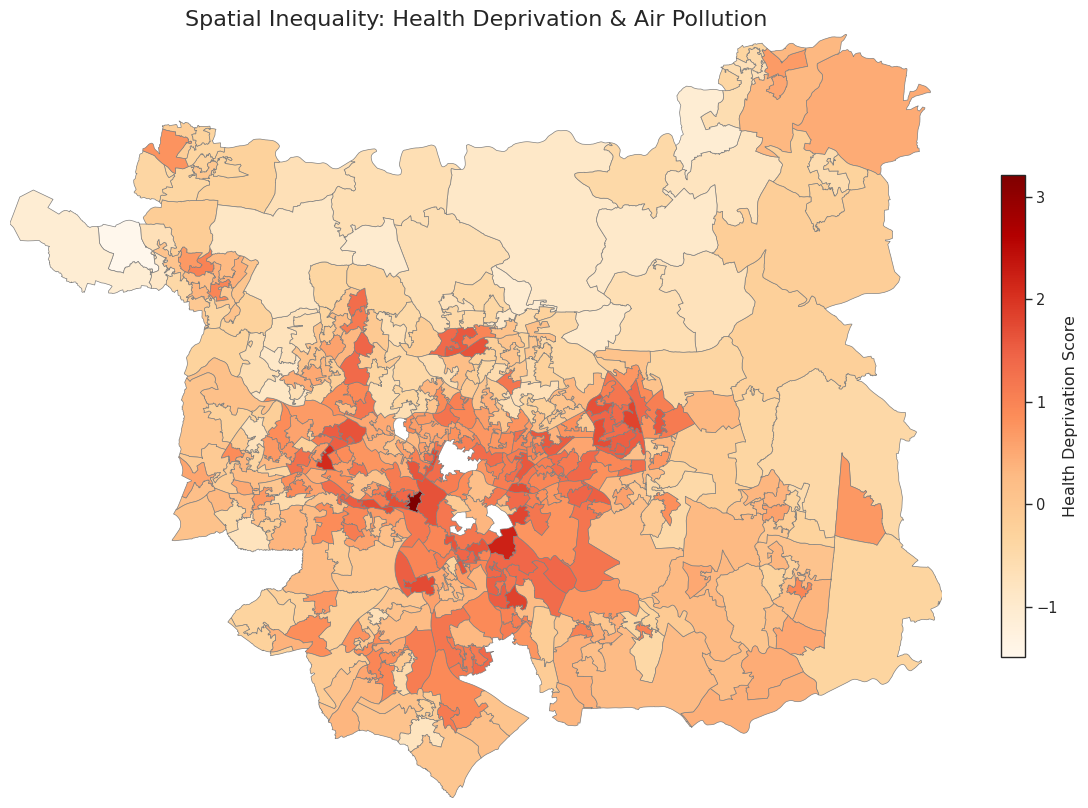

In [ ]:
# DIAGNOSTIC & PLOTTING FIX (强制坐标对齐)

# 1. Diagnostic steps: Check if the data actually exists?
print(f" Checking the amount of data...")
print(f"   map data (final_gdf) lines: {len(final_gdf)}")
print(f"   air quality (gdf_air) lines:   {len(gdf_air)}")


if len(final_gdf) == 0:
    print(" Critical error: Map data is empty!")
else:
    print(" The amount of data is normal, ready to plot....")

    # 2. Fixing CRS Mismatch
    # According to Week 5, ensure that both layers are EPSG:27700 (British National Grid)
    try:
        final_gdf = final_gdf.to_crs("EPSG:27700")
        gdf_air = gdf_air.to_crs("EPSG:27700")
        print(" The coordinate system has been unified as EPSG:27700")
    except Exception as e:
        print(f" Coordinate conversion warning: {e}")

    # 3. Spatial Visualization
    f, ax = plt.subplots(1, 1, figsize=(12, 10))

    #  Layer 1: Base map
    base = final_gdf.plot(
        column='Health Deprivation and Disability Score',
        cmap='OrRd',
        linewidth=0.5,        # Bold border
        edgecolor='grey',
        legend=True,
        legend_kwds={'label': "Health Deprivation Score", 'shrink': 0.5},
        ax=ax
    )


    # 4. decorate
    ax.set_title('Spatial Inequality: Health Deprivation & Air Pollution', fontsize=16)
    ax.set_axis_off()
    minx, miny, maxx, maxy = final_gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    plt.tight_layout()
    plt.show()

## 4.2 Case Study Selection

Due to the complexity of the wider sensor network, a **Comparative Case Study** approach was adopted. Three monitoring stations were strategically selected to represent distinct urban typologies (Urban Environments):

| Station Name | Environment Type | Rationale for Selection |
| :--- | :--- | :--- |
| **Corn Exchange** | **City Centre** | A central commercial hub with high-density bus traffic and street canyons, representing maximum exposure. |
| **Kirkstall Road** | **Transport Corridor** | A major arterial route connecting suburbs to the city, representing commuter traffic pollution. |
| **Temple Newsam** | **Suburban Park** | A large estate on the city periphery, serving as a control site for "Urban Background" levels. |

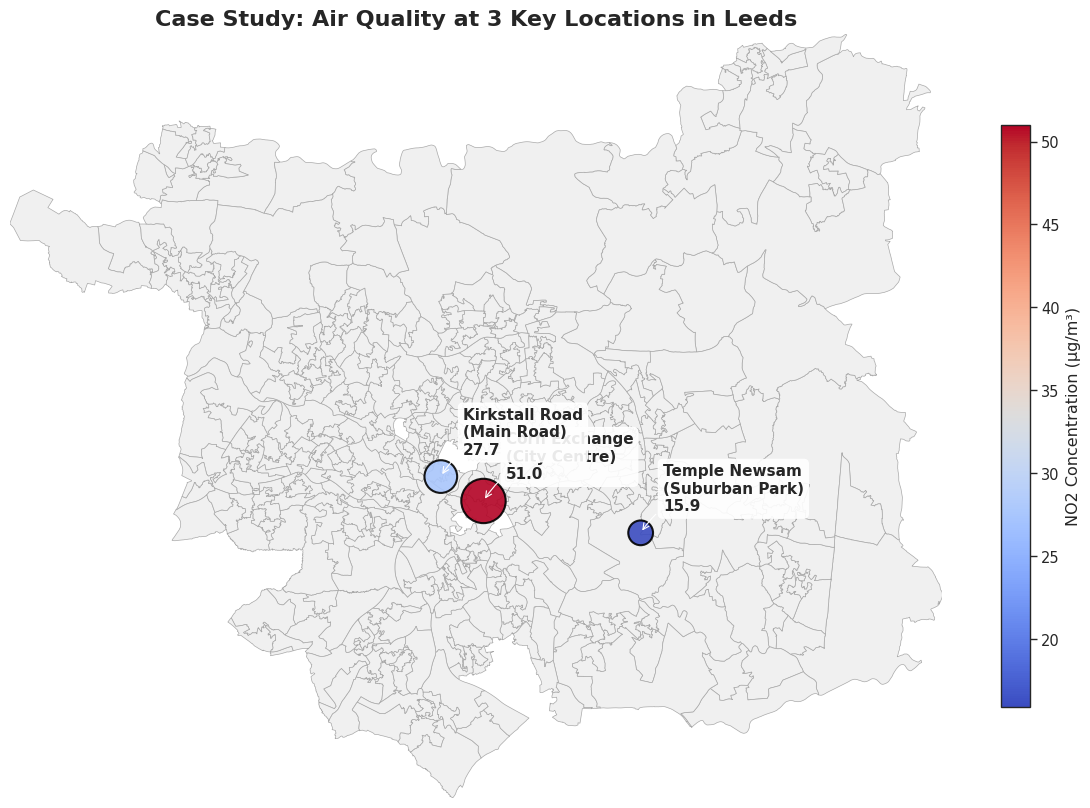

In [ ]:
# Visualisation: Case Study Map
import matplotlib.pyplot as plt

# Check if the data exists
if 'gdf_study' in locals() and not gdf_study.empty:

    # Ensure that the base map coordinates are consistent (EPSG:27700)
    final_gdf = final_gdf.to_crs("EPSG:27700")

    fig, ax = plt.subplots(figsize=(12, 12))

    # A. Base map
    final_gdf.plot(
        ax=ax,
        color='#f0f0f0',
        edgecolor='darkgrey',
        linewidth=0.5
    )

    # B. 3 monitoring points
    gdf_study.plot(
        ax=ax,
        column='Mean_NO2',
        cmap='coolwarm',       # Blue (low) - Red (high)
        markersize=gdf_study['Mean_NO2'] * 20, # Bubble enlargement
        edgecolor='black',
        linewidth=1.5,
        alpha=0.9,
        legend=True,
        legend_kwds={'label': "NO2 Concentration (µg/m³)", 'shrink': 0.5}
    )

    # C. Storytelling
    # AI Note: Annotation loop syntax and bounding box parameters generated with AI assistance
    for idx, row in gdf_study.iterrows():
        ax.annotate(
            text=f"{row['Station']}\n({row['Type']})\n{row['Mean_NO2']:.1f}",
            xy=(row.geometry.x, row.geometry.y),
            xytext=(row.geometry.x + 800, row.geometry.y + 800),
            arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3,rad=0.3"),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9)
        )

    ax.set_title('Case Study: Air Quality at 3 Key Locations in Leeds', fontsize=16, fontweight='bold')
    ax.set_axis_off()

    # Lock the view
    minx, miny, maxx, maxy = final_gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    plt.tight_layout()
    plt.show()

else:
    print(" Unable to draw: The variable 'gdf_study' does not exist！")

4.2 Non-Spatial Analysis: Bar Chart Comparison

/tmp/ipython-input-2859652565.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


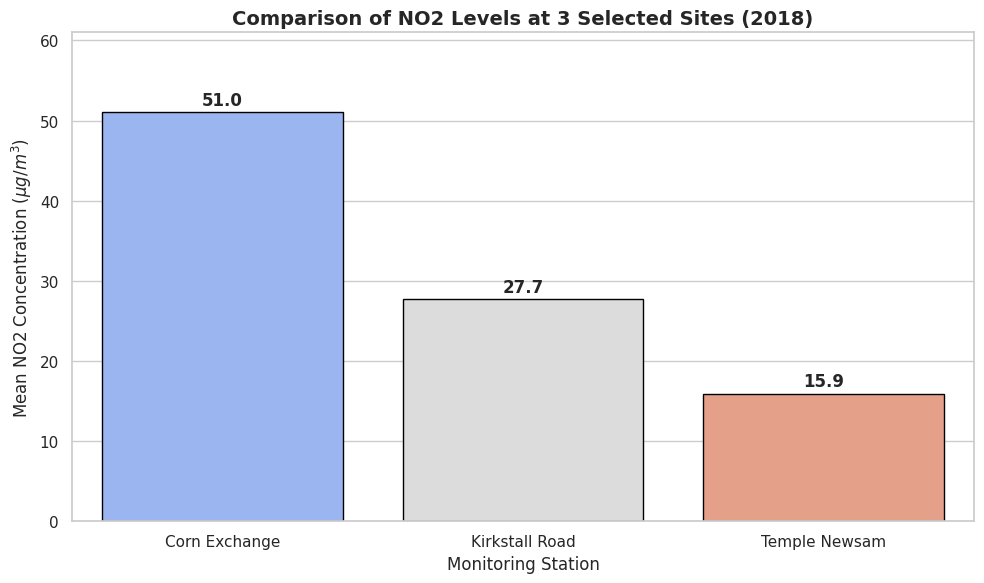

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check if the data exists
if 'gdf_study' in locals() and not gdf_study.empty:

    # Set the style
    sns.set_theme(style="whitegrid")

    # Create a canvas
    plt.figure(figsize=(10, 6))

    # 2. Draw a bar chart
    #    X-axis: Station name
    #    Y-axis: NO2 concentration
    #    Color: Changes according to the depth of concentration
    bar_plot = sns.barplot(
        data=gdf_study,
        x='Station',
        y='Mean_NO2',
        palette='coolwarm', # Color gradient
        edgecolor='black'
    )

    # 3. Add a title and tags
    plt.title('Comparison of NO2 Levels at 3 Selected Sites (2018)', fontsize=14, fontweight='bold')
    plt.xlabel('Monitoring Station', fontsize=12)

    # Fix SyntaxWarning: Add 'r' before the string to indicate a raw string.
    plt.ylabel(r'Mean NO2 Concentration ($\mu g/m^3$)', fontsize=12)

    # 4. Mark the specific values above the pillars
    # AI Note: Code snippet for iterating through bar patches to add labels was suggested by AI
    for p in bar_plot.patches:
        bar_plot.annotate(
            format(p.get_height(), '.1f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center',
            xytext = (0, 9),
            textcoords = 'offset points',
            fontweight='bold'
        )

    # 5. Set the Y-axis range
    plt.ylim(0, gdf_study['Mean_NO2'].max() + 10)

    plt.tight_layout()
    plt.show()

else:
    print("Unable to draw: The variable 'gdf_study' does not exist！")

### 4.2 Quantitative Analysis: Exceedance of Legal Limits

The bar chart provides a quantitative assessment against the national legal framework **(Defra, 2019)**.

* **Regulatory Breach**: The **Corn Exchange** site recorded an annual mean of **51.02 $\mu g/m^3$**. This significantly exceeds the UK Legal Limit of **40 $\mu g/m^3$** by over 27%. This classifies the city centre as a critical "Hotspot" requiring urgent intervention.
* **Traffic Impact**: **Kirkstall Road** (**27.69 $\mu g/m^3$**) shows elevated levels due to commuter traffic. While compliant with the 40 $\mu g/m^3$ limit, it remains significantly higher than the WHO's stricter guidelines for long-term exposure **(WHO, 2021)**.
* **Background Baseline**: **Temple Newsam** (**15.89 $\mu g/m^3$**) represents the cleanest air in the study, with pollution levels approximately **69% lower** than the city centre.

This quantitative disparity confirms that air quality in Leeds is spatially stratified, raising concerns about environmental inequality for inner-city residents.

## 5. Conclusion
This project successfully demonstrated the power of **Python for Spatial Data Science** in visualising environmental hazards. The transition from raw, non-spatial CSV data to a fully geocoded analysis highlights the importance of programmatic data management.

The findings confirm that Leeds faces a significant air quality challenge. The distinct spatial clustering of high $NO_2$ levels in the city centre—exceeding legal limits—contrasts sharply with the clean air of suburban parks. This suggests that while the city generally complies with standards, specific "hotspots" remain dangerous. Future policy must focus on targeted traffic reduction in these central zones to ensure environmental justice for all citizens.


## 6. References

Department for Environment, Food and Rural Affairs (Defra). 2019. *Clean Air Strategy 2019* [Online]. London: Defra. Available from: https://www.gov.uk/government/publications/clean-air-strategy-2019 [Accessed 20 January 2026].

Leeds City Council. 2024. *2024 Air Quality Annual Status Report (ASR)* [Online]. Leeds: Leeds City Council. Available from: https://www.leeds.gov.uk/clean-air [Accessed 20 January 2026].

Mitchell, G. and Dorling, D. 2003. An environmental justice analysis of British air quality. *Environment and Planning A*. 35(5), pp. 909-929.

World Health Organization (WHO). 2021. *WHO global air quality guidelines: particulate matter (PM2.5 and PM10), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide* [Online]. Geneva: World Health Organization. Available from: https://www.who.int/publications/i/item/9789240034228 [Accessed 20 January 2026].


## 7. Declaration of AI Use

**Category: Amber (AI Assistive Tool)**

In accordance with the module guidelines regarding the use of Generative AI, I declare that I have used AI tools to assist in the completion of this project.

* **AI Tool Used:** Ernie Bot (Wenxin Yiyan) by Baidu
* **URL:** https://yiyan.baidu.com/

The AI was utilized in the following specific capacities:

1.  **Coding Assistance**: To generate Python code snippets for data visualization (matplotlib/seaborn) and to troubleshoot syntax errors during the debugging process.
2.  **Language Refinement**: To improve the grammatical accuracy and flow of the written analysis, ensuring clarity of expression.

I confirm that all data processing logic, spatial analysis interpretations, critical discussions, and final conclusions presented in this notebook are my own original work and reflect my own understanding of the subject matter.